[Reference](https://medium.com/@kenanekici/visualizing-multicollinearity-in-python-b5feedc9b3f1)

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
from ipywidgets import Layout, widgets
from google.colab import output
output.enable_custom_widget_manager()
import math
import matplotlib.dates as md
!pip install yfinance
import yfinance as yf
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

# S&P500 metadata
sp500_table = payload[0]

# mappings 
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table["GICS Sector"].values
sp500_sub_sectors = sp500_table["GICS Sub-Industry"].values
sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))
sector_color_mapping = dict(zip(sp500_sectors, sns.color_palette("pastel", len(sp500_sectors)).as_hex()))
subsector_color_mapping = dict(zip(sp500_sub_sectors, sns.color_palette("pastel", len(sp500_sub_sectors)).as_hex()))

# download S&P500 financial data
tickers = list(sp500_tickers)
prices = yf.download(tickers, start="2020-01-01", end="2021-12-31", interval='1d')
prices = prices["Adj Close"]
prices = prices.rename(columns=sp500_names_mapping)
prices

# impute
for i, row in prices.iterrows():
  if row.isnull().mean() > 0.9: prices.drop(i, inplace=True)
prices = prices.loc[:, prices.isnull().mean() < 0.3]
prices = prices.fillna(method='bfill')
print(prices.shape)

# calculate rolling correlation
corr = prices.rolling(60).corr()
corr_ = np.array([corr.loc[i].to_numpy() for i in prices.index if not np.isnan(corr.loc[i].to_numpy()).all()])
corr_ = np.nansum(corr_, axis=0)/len(corr_)
corr_ = pd.DataFrame(columns=prices.columns.tolist(), index=prices.columns.tolist(), data=corr_)

     |████████████████████████████████| 6.4 MB 9.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1577836800, endDate = 1640908800

# The heatmap


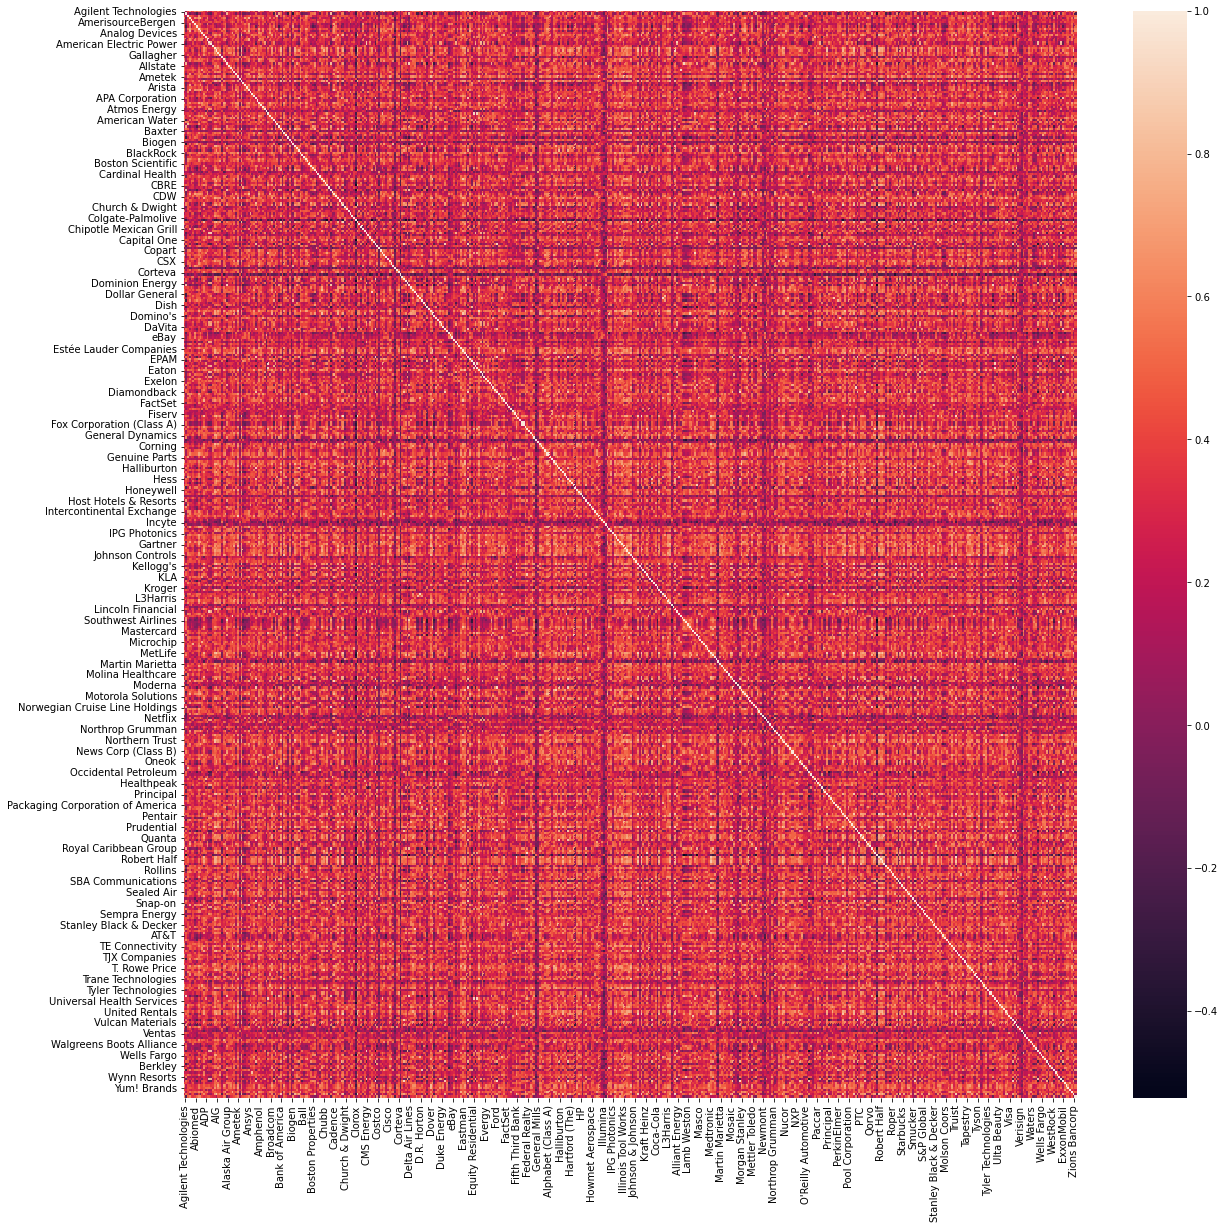

In [2]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_)

# The clustermap


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


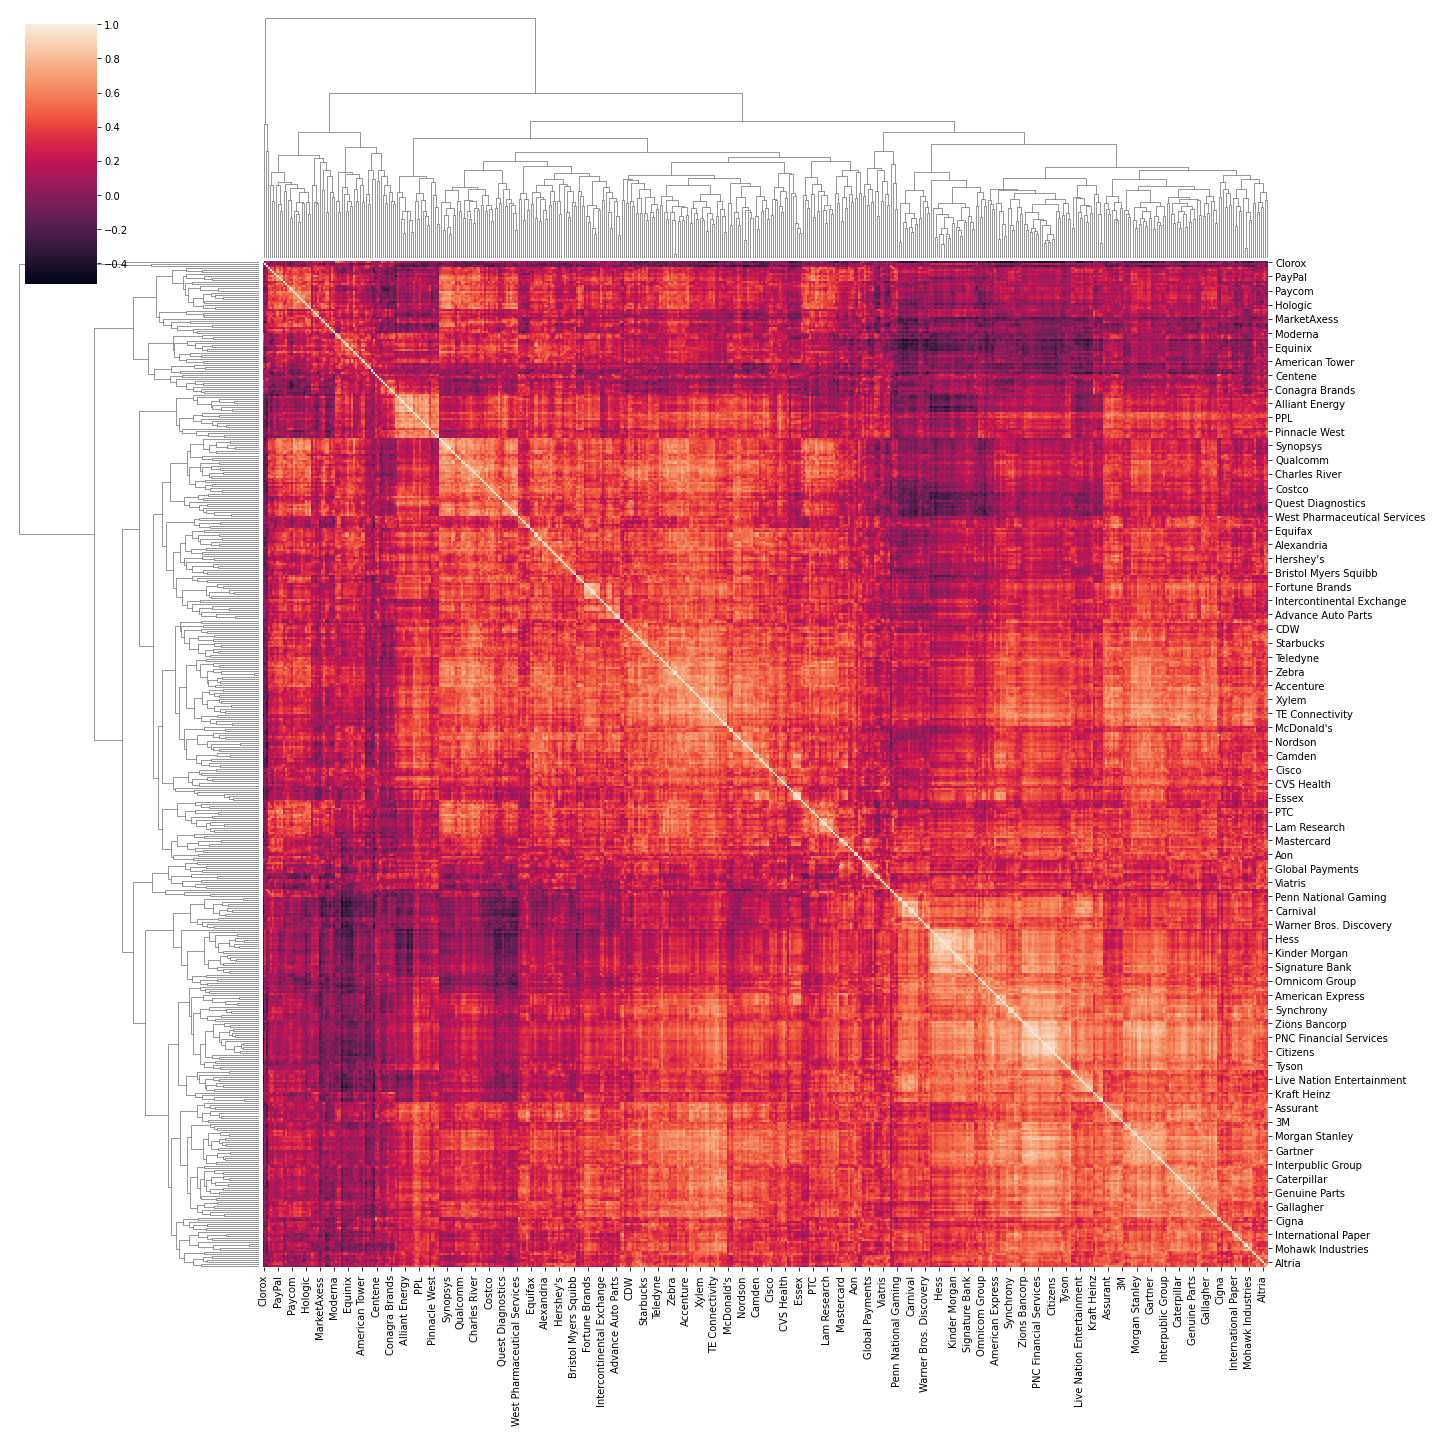

In [3]:
sns.clustermap(corr_, figsize=(20,20))

# The network graph


In [4]:
threshold_choice = widgets.FloatSlider(description="Threshold", value=0.8, min=0.5, max=1, step=0.05, continuous_update=False, 
                                       orientation='horizontal', layout=Layout(width='500px'), style=dict(description_width= 'initial'))
network = go.FigureWidget(data=[go.Scatter(x=[], y=[], mode='lines', text=[],  line=dict(color='MediumPurple', width=10), marker=dict(size=20, line_width=10,line=dict(color='MediumPurple',width=2))),
                                 go.Scatter(x=[], y=[],mode='markers+text', textposition="top center", text=[],hoverinfo='text',textfont_size=12, marker=dict(size=50, color=[],line_width=1))],
                          layout=go.Layout( showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0), width=1600, height=800))
df = prices.copy()
correlation_matrix = corr_.to_numpy()

def plot_corr_graph(change):
    threshold, corr_mode = None, None
    threshold = change.new
    
    tr_ind = np.triu_indices(correlation_matrix.shape[0])
    correlation_matrix[tr_ind] = 0
    G = nx.from_numpy_matrix(correlation_matrix)
    G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
    # 49 x 49 - 49 (self corr) / 2 (remove upper triang)
    remove = []
    
    for col1, col2, weight in G.edges(data=True):
      if math.isnan(weight["weight"]):
        remove.append((col1,col2))
    
      if abs(weight["weight"]) < threshold:
        remove.append((col1,col2))
    
    G.remove_edges_from(remove)
    
    remove = []
    edges = list(sum(G.edges, ()))
    
    for node in G.nodes:
      if node not in edges:
        remove.append(node)
    G.remove_nodes_from(remove)
    mst = nx.maximum_spanning_tree(G)
    
    def assign_color(col):
      return sector_color_mapping[sp500_sector_mapping[col]]
    def assign_color_edge(correlation):
      if correlation < 0:
        return "#BF0603"
      else:
        return "#00CC66"
    edge_colors = []
    node_colors = []
    for key, value in nx.get_edge_attributes(mst, 'weight').items():
        edge_colors.append(assign_color_edge(value))
    for key, value in dict(mst.degree).items():
        node_colors.append(assign_color(key))
      
    labels = {n:n for n in mst.nodes()}
    node_x = []
    node_y = []
    
    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()
    
    for node, (x_,y_) in tree:
        node_x.append(x_)
        node_y.append(y_)
        
    def get_dim_of_node(name):
        for node, (x,y) in tree:
            if node == name:
                return x,y
        
    edge_x = []
    edge_y = []
    
    weights= []
    for node1, node2, w in mst.edges(data=True):
        x0, y0 = get_dim_of_node(node1)
        x1, y1 =  get_dim_of_node(node2)
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append((round(w["weight"],1), (x0+x1)/2, (y0+y1)/2))
                              
    with network.batch_update():
        network.data[1].x = node_x
        network.data[1].y = node_y
        network.data[1].text = list(labels)
        network.data[1].marker.color = node_colors
                          
        network.data[0].x = edge_x
        network.data[0].y = edge_y
        network.data[0].text = list(weights)
        network.update_layout(xaxis_zeroline=False, yaxis_zeroline=False, xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor='rgba(0,0,0,0)')

threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice, network])